# Exercise 1
## JIT the pressure poisson equation
The equation we need to unroll is given by 

\begin{equation}
p_{i,j}^{n} = \frac{1}{4}\left(p_{i+1,j}^{n}+p_{i-1,j}^{n}+p_{i,j+1}^{n}+p_{i,j-1}^{n}\right) - b
\end{equation}

and recall that `b` is already computed, so no need to worry about unrolling that.  We've also filled in the boundary conditions, so don't worry about those.  (don't forget to decorate your function!)

In [2]:
import numpy
from numba import jit

In [32]:
@jit
def pressure_poisson(p, b, l2_target=1e-4):
    I, J = b.shape
        
    iter_diff = l2_target + 1
    n = 0
    while iter_diff > l2_target and n <= 500:
        pn = p.copy() # we need to make a copy because p is updated for t+1 and pn is at y
                        # ie we are drawing from i+-1 and j+-1 and these values would be changed 
        
        #Your code here
        for i in range(1,I-1):
            for j in range(1,J-1):
                p[i,j] = 0.25*(pn[i+1,j]+
                               pn[i-1,j]+
                               pn[i,j+1]+
                               pn[i,j-1]
                              ) - b[i,j]
                            
        
        #boundary conditions
        for i in range(I):
            p[i, 0] = p[i, 1]
            p[i, -1] = 0

        for j in range(J):
            p[0, j] = p[1, j]
            p[-1, j] = p[-2, j]

        if n % 10 == 0:
            iter_diff = numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))
            
        n += 1
        
    return p

In [3]:
import pickle
from snippets.ns_helper import cavity_flow, velocity_term, quiver_plot

In [34]:
def run_cavity():
    nx = 41
    with open('../IC.pickle', 'rb') as f:
        u, v, p, b = pickle.load(f)

    dx = 2 / (nx - 1)
    dt = .005
    nt = 1000
    
    u, v, p = cavity_flow(u, v, p, nt, dt, dx,
                         velocity_term,
                         pressure_poisson,
                         rtol=1e-4)

    return u, v, p

In [35]:
un, vn, pn = run_cavity()

In [10]:
%matplotlib inline

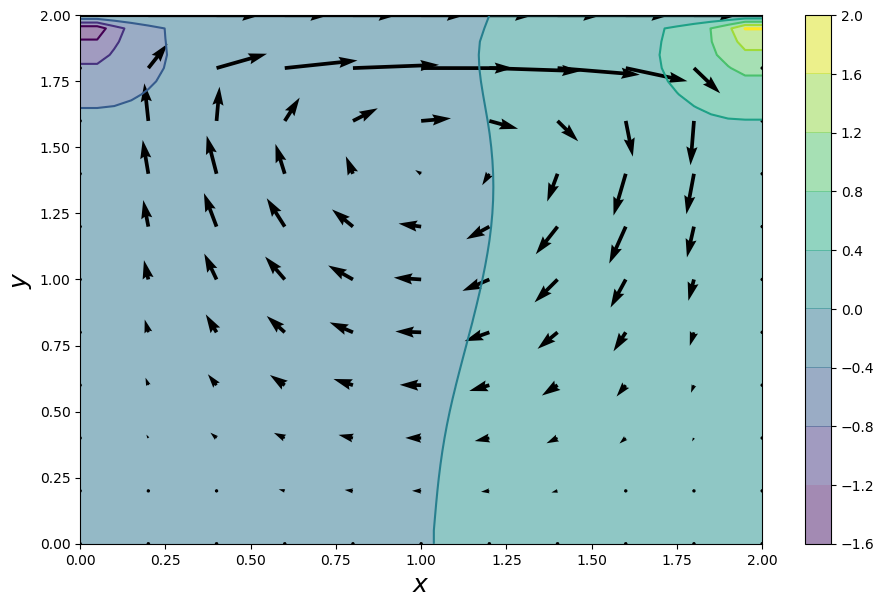

In [28]:
quiver_plot(u, v, p)

In [18]:
%timeit run_cavity()

222 ms ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%load_ext line_profiler

In [25]:
%lprun -f cavity_flow run_cavity()

We got a 2.7x speed up. If we compate the `lprun` logs we see the `p = pressure_poisson(p, b, rtol)` line was sped up by a factor of 9.9

In [4]:
with open('../numpy_ans.pickle', 'rb') as f:
    u, v, p = pickle.load(f)

In [22]:
assert numpy.allclose(u, un)
assert numpy.allclose(v, vn)
assert numpy.allclose(p, pn)

# Exercise 2 (optional)

Finish early?  Just want to try more stuff?  

This line is not super efficient: 

```python
iter_diff = numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))
```

Try rewriting it using a jitted function and see what kind of performance gain you can get.

In [5]:
@jit
def pressure_poisson(p, b, l2_target=1e-4):
    I, J = b.shape
        
    iter_diff = l2_target + 1
    n = 0
    while iter_diff > l2_target and n <= 500:
        pn = p.copy() # we need to make a copy because p is updated for t+1 and pn is at y
                        # ie we are drawing from i+-1 and j+-1 and these values would be changed 
        
        #Your code here
        for i in range(1,I-1):
            for j in range(1,J-1):
                p[i,j] = 0.25*(pn[i+1,j]+
                               pn[i-1,j]+
                               pn[i,j+1]+
                               pn[i,j-1]
                              ) - b[i,j]
                            
        
        #boundary conditions
        for i in range(I):
            p[i, 0] = p[i, 1]
            p[i, -1] = 0

        for j in range(J):
            p[0, j] = p[1, j]
            p[-1, j] = p[-2, j]

        if n % 10 == 0:
            iter_diff_n=0
            iter_diff_d=0
            for i in range(I):
                for j in range(J):
                    iter_diff_n += (p[i,j] - pn[i,j])**2
                    iter_diff_d += pn[i,j]**2
            iter_diff = iter_diff_n/iter_diff_d
                                
        n += 1
        
    return p

In [6]:
def run_cavity():
    nx = 41
    with open('../IC.pickle', 'rb') as f:
        u, v, p, b = pickle.load(f)

    dx = 2 / (nx - 1)
    dt = .005
    nt = 1000
    
    u, v, p = cavity_flow(u, v, p, nt, dt, dx,
                         velocity_term,
                         pressure_poisson,
                         rtol=1e-4)

    return u, v, p

In [8]:
un, vn, pn = run_cavity()

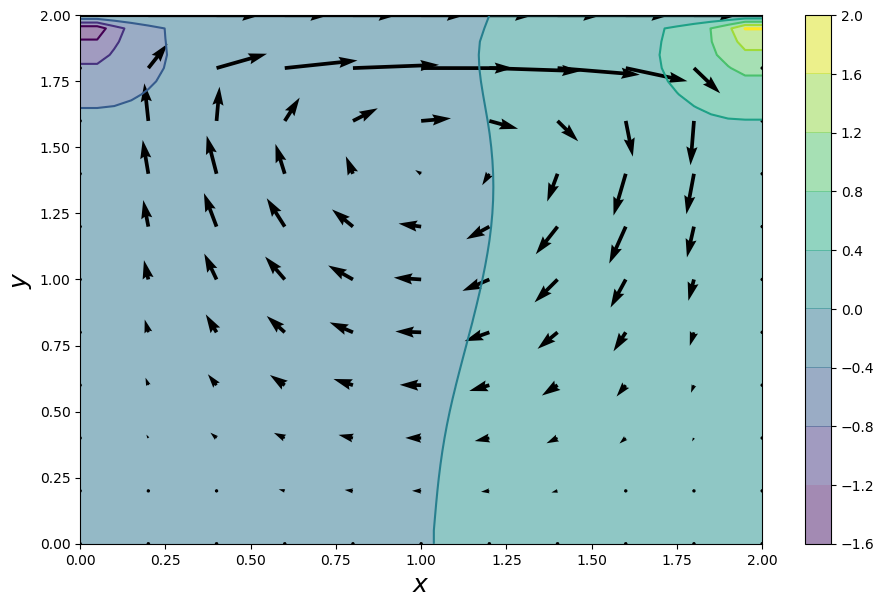

In [11]:
quiver_plot(u, v, p)

In [12]:
%timeit run_cavity()

190 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
%lprun -f cavity_flow run_cavity()

We got a further 4.1x speedup on `p = pressure_poisson(p, b, rtol)` by computing `iter_diff` with (jitted) loops. In total we are getting a 3.2x speedup on `run_cavity()`.